In [3]:
import os
import numpy as np
from py3helpers.aws import AwsS3
from py3helpers.utils import create_dot_dict
from rrna_analysis.plot_experiment_table import plot_acc_heatmap_for_experiment
from rrna_analysis.multiple_model_accuracy import plot_accuracy_vs_delta_and_accuracy_over_time, preprocess_accuracy_csv
from rrna_analysis.kmer_pos_mapping import KmerPosMapping
import pandas as pd
from py3helpers.classification import ClassificationMetrics
from signalalign.visualization.plot_multiple_variant_accuracy import load_positions_file, get_prob_and_label, load_sa2bed_variant_data, create_master_table
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm, entropy, pearsonr
import matplotlib.colors as mcolors


mods_csv = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/mod_files/mod_file.csv"
reference = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/yeast_25S_18S.fa"
positions = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/mod_files/yeast_18S_25S_variants.positions"
kpm = KmerPosMapping(reference, positions, mods_csv)

In [4]:
output_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/figures/depletion"
pseduo_u = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/misc_pos_files/pseudo_u.positions"
two_prime = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/misc_pos_files/twoprime.positions"

In [5]:
pseduo_u_df = pd.read_csv(pseduo_u)
twoprimeo_df = pd.read_csv(two_prime)
both_df = pd.concat([pseduo_u_df, twoprimeo_df])

In [6]:
# depletion experiments
_depletion_07_ivt_and_native_only = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/small_5mer/test_with_depletions/train_500_test_500_prob_0.7_em_iterations_30_gaussian_true_FREQ_THRESHOLD_0_USE_IVT_TRAINING_true_unsupervised_false_all_kmers_false_small_model_5mer_use_median_true_min_sd_0"
_depletion_07 = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/small_5mer/depletion/train_500_test_500_prob_0.7_em_iterations_30_gaussian_true_FREQ_THRESHOLD_0_USE_IVT_TRAINING_true_unsupervised_false_all_kmers_false_small_model_5mer_use_median_true_min_sd_0"

methyl_pos = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/small_models/small_5mer/yeast_18S_25S_Omethyl_knockdown.positions"
pseduo_pos = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/small_models/small_5mer/yeast_18S_25S_pseudoU_knockdown.positions"
canonical_pos = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/small_models/small_5mer/yeast_18S_25S_canonical.positions"
native_pos = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/small_models/small_5mer/yeast_18S_25S_modified.positions"


In [7]:
round_n = 30
threshold = 0.5
methyl_ext1 = f"all_variant_calls/template_hmm{round_n}/run_nop_glu.csv"
pseduoU_ext2 = f"all_variant_calls/template_hmm{round_n}/run_cbf5_glu.csv"
canonical_ext3 = f"all_variant_calls/template_hmm{round_n}/canonical_ivt.csv"
native_ext4 = f"all_variant_calls/template_hmm{round_n}/native_cbf5_gal.csv"

In [8]:
def get_selector(kpm, delta):
    a = (((~kpm.mod_handler.change_to.shift(1).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) &
         (kpm.mod_handler.delta1_below == delta)) |
        (~kpm.mod_handler.change_to.shift(-1).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) &
         (kpm.mod_handler.delta1_above == delta)) |
        (~kpm.mod_handler.change_to.shift(2).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) &
         (kpm.mod_handler.delta2_below == delta)) |
        (~kpm.mod_handler.change_to.shift(-2).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) &
         (kpm.mod_handler.delta2_above == delta)) |
        (~kpm.mod_handler.change_to.shift(3).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) &
         (kpm.mod_handler.delta3_below == delta)) |
        (~kpm.mod_handler.change_to.shift(-3).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) &
         (kpm.mod_handler.delta3_above == delta)) |
        (~kpm.mod_handler.change_to.shift(4).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) &
         (kpm.mod_handler.delta4_below == delta)) |
        (~kpm.mod_handler.change_to.shift(-4).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) &
         (kpm.mod_handler.delta4_above == delta))
    ) & (kpm.mod_handler.change_to.isin(["Aa", "Cb", "Gc", "Td", "Tdm"])))
    b = (((~kpm.mod_handler.change_to.shift(1).isin(["Tl"]) &
         (kpm.mod_handler.delta1_below == delta)) |
        (~kpm.mod_handler.change_to.shift(-1).isin(["Tl"]) &
         (kpm.mod_handler.delta1_above == delta)) |
        (~kpm.mod_handler.change_to.shift(2).isin(["Tl"]) &
         (kpm.mod_handler.delta2_below == delta)) |
        (~kpm.mod_handler.change_to.shift(-2).isin(["Tl"]) &
         (kpm.mod_handler.delta2_above == delta)) |
        (~kpm.mod_handler.change_to.shift(3).isin(["Tl"]) &
         (kpm.mod_handler.delta3_below == delta)) |
        (~kpm.mod_handler.change_to.shift(-3).isin(["Tl"]) &
         (kpm.mod_handler.delta3_above == delta)) |
        (~kpm.mod_handler.change_to.shift(4).isin(["Tl"]) &
         (kpm.mod_handler.delta4_below == delta)) |
        (~kpm.mod_handler.change_to.shift(-4).isin(["Tl"]) &
         (kpm.mod_handler.delta4_above == delta))
        ) & (kpm.mod_handler.change_to.isin(["Tl"])))
    c = (((kpm.mod_handler.change_to.shift(1).isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"]) &
         (kpm.mod_handler.delta1_below == delta)) |
        (kpm.mod_handler.change_to.shift(-1).isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"]) &
         (kpm.mod_handler.delta1_above == delta)) |
        (kpm.mod_handler.change_to.shift(2).isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"]) &
         (kpm.mod_handler.delta2_below == delta)) |
        (kpm.mod_handler.change_to.shift(-2).isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"]) &
         (kpm.mod_handler.delta2_above == delta)) |
        (kpm.mod_handler.change_to.shift(3).isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"]) &
         (kpm.mod_handler.delta3_below == delta)) |
        (kpm.mod_handler.change_to.shift(-3).isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"]) &
         (kpm.mod_handler.delta3_above == delta)) |
        (kpm.mod_handler.change_to.shift(4).isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"]) &
         (kpm.mod_handler.delta4_below == delta)) |
        (kpm.mod_handler.change_to.shift(-4).isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"]) &
         (kpm.mod_handler.delta4_above == delta))
        ) & (~kpm.mod_handler.change_to.isin(["Aa", "Cb", "Gc", "Td", "Tdm", "Tl"])))

    hits1 = a | b | c
    return hits1

In [9]:
def get_accuracy_data_from_sample(sample, threshold=0.5, round_n=30):
    all_data = []
    for sample in samples:
        sample = create_dot_dict(sample)
        variants = load_sa2bed_variant_data(sample.variant_csv)
        positions = load_positions_file(sample.positions_file)
        assert len(positions) == len("".join(positions["label"])), "Positions file must have only one value for label"
        sample_data = create_master_table(positions, variants)
        if sample_data is not None:
            all_data.append(sample_data)
    assert len(all_data) > 0, \
        "No variants overlap with positions within all the samples. Check positions file and variants file"
    all_data_df = pd.concat(all_data)

    acc_data = []
    for x, y in all_data_df.groupby(['contig', 'reference_index', "strand", "variants"], as_index=False):
#         print("_".join([str(i) for i in x]))
        labels, probs, label_ids = get_prob_and_label(y)
        if len(labels) != 0:
            cm = ClassificationMetrics(labels,
                                       probs,
                                       label_ids=label_ids)
            if cm is None:
                print("Error on ", "_".join([str(i) for i in x]))
            else:
                class_n = probs.columns[-1]
                rocauc = cm.roc_auc[class_n]
                avg_precision = cm.get_average_precision(class_n)
                brier_score = cm.brier_score[class_n]
                accuracy = cm.accuracy(class_n, threshold=threshold)
                precision = cm.precision(class_n, threshold=threshold)
                negative_predictive_value = cm.negative_predictive_value(class_n, threshold=threshold)
                recall = cm.recall(class_n, threshold=threshold)
                specificity = cm.specificity(class_n, threshold=threshold)
                positive_likelihood_ratio = cm.positive_likelihood_ratio(class_n, threshold=threshold)
                negative_likelihood_ratio = cm.negative_likelihood_ratio(class_n, threshold=threshold)
                diagnostic_odds_ratio = cm.diagnostic_odds_ratio(class_n, threshold=threshold)
                f1_score = cm.f1_score(class_n, threshold=threshold)
                prevalence = cm.prevalence(class_n)
                line = [i for i in x] + [
                    round(accuracy, 4),
                    round(precision, 4),
                    round(negative_predictive_value, 4),
                    round(recall, 4),
                    round(specificity, 4),
                    round(positive_likelihood_ratio, 4),
                    round(negative_likelihood_ratio, 4),
                    round(diagnostic_odds_ratio, 4),
                    round(f1_score, 4),
                    round(prevalence, 4),
                    round(rocauc, 4),
                    round(avg_precision, 4),
                    round(brier_score, 4)]
                acc_data.append(line)
    return pd.DataFrame(acc_data, columns=["contig", "reference_index", "strand", "variants", "accuracy", "precision", "negative_predictive_value", "recall", "specificity", "positive_likelihood_ratio", "negative_likelihood_ratio", "diagnostic_odds_ratio", "f1_score", "prevalence", "aucroc", "avg_precision", "brier_score"])         

# Plot canoncial accuracy with both training rounds

In [10]:
key = "accuracy"


In [11]:
experiment_path = _depletion_07
samples = [{"variant_csv": os.path.join(experiment_path, canonical_ext3),
         "positions_file": canonical_pos},
          {"variant_csv": os.path.join(experiment_path, native_ext4),
         "positions_file": native_pos}]
depletions = get_accuracy_data_from_sample(samples)

experiment_path = _depletion_07_ivt_and_native_only
samples = [{"variant_csv": os.path.join(experiment_path, canonical_ext3),
         "positions_file": canonical_pos},
          {"variant_csv": os.path.join(experiment_path, native_ext4),
         "positions_file": native_pos}]
ivt_and_native = get_accuracy_data_from_sample(samples)


<IPython.core.display.Javascript object>


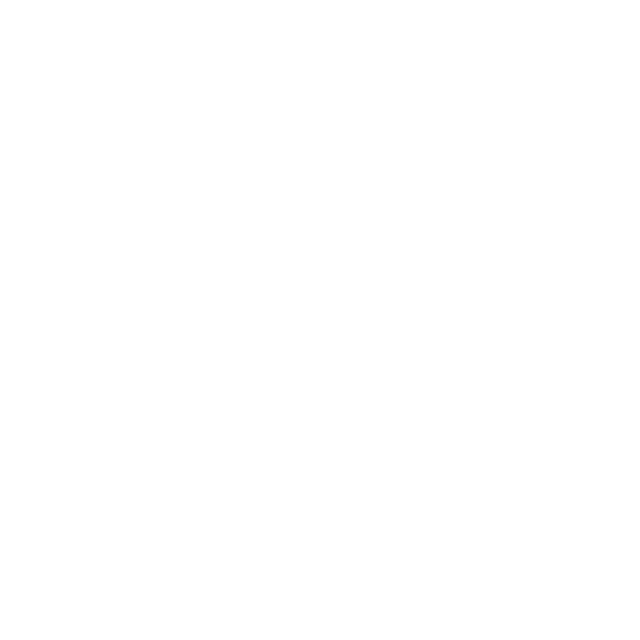

gap 1: {104, 85, 86, 103}
gap 2: {102, 70, 71, 105, 106, 75, 76, 82, 83}
gap 3: {32, 77, 80, 81, 31}
gap 4: {37, 38, 72, 107, 84, 23, 24}
gap 5: {99, 100, 87, 39}


In [12]:
%matplotlib notebook
f, panel1 = plt.subplots(figsize=(8, 8))
panel1.set_title(f'Depletion Training: \nDepletion testing {key} Vs IVT and Native testing {key}')
panel1.set_xlabel(f"Depletion testing {key}")
panel1.set_ylabel(f"IVT and Native testing {key}")
linspace = np.linspace(.5,1,100)
legends = []

seen = set()

for delta in range(1, 6):
    hits1 = get_selector(kpm, delta)
    hits = set(hits1[hits1].index.values) - seen
    print(f"gap {delta}: {hits}")
    seen |= hits            

iso_dep = depletions.loc[~depletions.index.isin(list(seen))][key]
iso_ivt_native = ivt_and_native.loc[~ivt_and_native.index.isin(list(seen))][key]
pearson_r, pvalue = pearsonr(iso_dep, iso_ivt_native)
ax = panel1.scatter(iso_dep, iso_ivt_native, 
                    label=f"Unchanged Kmer Paths\n Number Positions: {len(iso_ivt_native)}\n Pearson Correlation: {round(pearson_r, 2)}")

legends.append(ax)

changed_dep = depletions.loc[depletions.index.isin(list(seen))][key]
changed_ivt_native = ivt_and_native.loc[ivt_and_native.index.isin(list(seen))][key]
pearson_r, pvalue = pearsonr(changed_dep, changed_ivt_native)
ax = panel1.scatter(changed_dep, changed_ivt_native, 
                    label=f"Changed Kmer Paths\n Number Positions: {len(changed_ivt_native)}\n Pearson Correlation: {round(pearson_r, 2)}")

legends.append(ax)

ax, = panel1.plot(linspace, linspace, '-r', linewidth=2, label='Perfect Match')
legends.append(ax)

panel1.legend(handles=legends, loc="lower right")
plt.show()


<IPython.core.display.Javascript object>


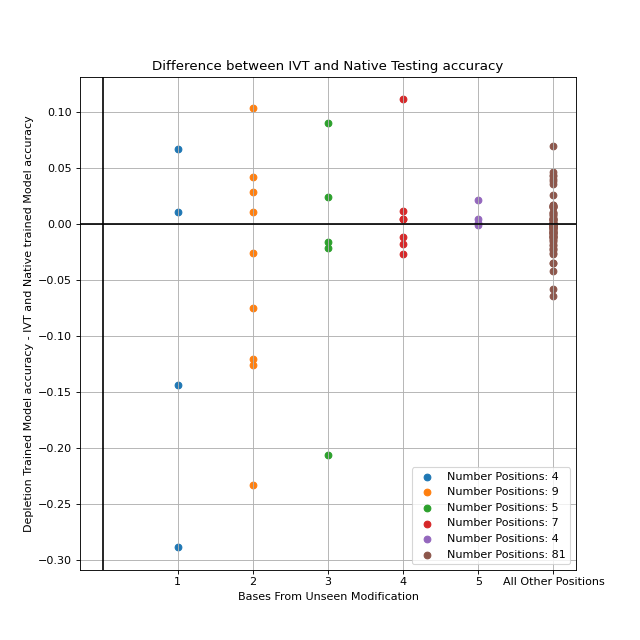

gap 1: {104, 85, 86, 103}
gap 2: {102, 70, 71, 105, 106, 75, 76, 82, 83}
gap 3: {32, 77, 80, 81, 31}
gap 4: {37, 38, 72, 107, 84, 23, 24}
gap 5: {99, 100, 87, 39}


In [13]:
%matplotlib notebook
# matplotlib.use('SVG')
# plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(output_path, "missing_kmer_accuracy_ivt_and_native.svg")
figure_path = None

f, panel1 = plt.subplots(figsize=(8, 8))
panel1.set_title(f'Difference between IVT and Native Testing {key}')
panel1.set_ylabel(f"Depletion Trained Model {key} - IVT and Native trained Model {key}")
panel1.set_xlabel(f"Bases From Unseen Modification")
panel1.set_xticks([x for x in range(1, 7)])
panel1.set_yticks([x for x in np.arange(-1, 1, 0.05)])

panel1.set_xticklabels([str(x) for x in range(1, 6)] + ["All Other Positions"])
panel1.grid()
data = []
seen = set()

for delta in range(1, 6):
    hits1 = get_selector(kpm, delta)
    hits = set(hits1[hits1].index.values) - seen
    print(f"gap {delta}: {hits}")
    tmp_data = (depletions.iloc[list(hits)][key] - ivt_and_native.iloc[list(hits)][key])
    seen |= hits
    data.append(tmp_data)
    panel1.scatter([delta] * len(tmp_data), tmp_data, label=f"Number Positions: {len(tmp_data)}")

tmp_data = (depletions.loc[~depletions.index.isin(list(seen))][key] - 
            ivt_and_native.loc[~ivt_and_native.index.isin(list(seen))][key])

panel1.scatter([delta+1] * len(tmp_data), tmp_data, label=f"Number Positions: {len(tmp_data)}")

panel1.axhline(y=0, color='k')
panel1.axvline(x=0, color='k')

# panel1.boxplot(data)
panel1.legend(loc="lower right")
if figure_path is not None:
#         assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
    plt.savefig(figure_path)
else:
    plt.show()


## Plot how learning specific kmers improves accuracy in regions where we don't know the kmer distribution


In [14]:
experiment_path = _depletion_07
samples = [{"variant_csv": os.path.join(experiment_path, pseduoU_ext2),
         "positions_file": pseduo_pos},
          {"variant_csv": os.path.join(experiment_path, methyl_ext1),
         "positions_file": methyl_pos}]
depletions = get_accuracy_data_from_sample(samples)

experiment_path = _depletion_07_ivt_and_native_only
samples = [{"variant_csv": os.path.join(experiment_path, pseduoU_ext2),
         "positions_file": pseduo_pos},
          {"variant_csv": os.path.join(experiment_path, methyl_ext1),
         "positions_file": methyl_pos}]
ivt_and_native = get_accuracy_data_from_sample(samples)


In [15]:
figure_path = os.path.join(output_path, "missing_kmer_accuracy.svg")
figure_path = None

<IPython.core.display.Javascript object>


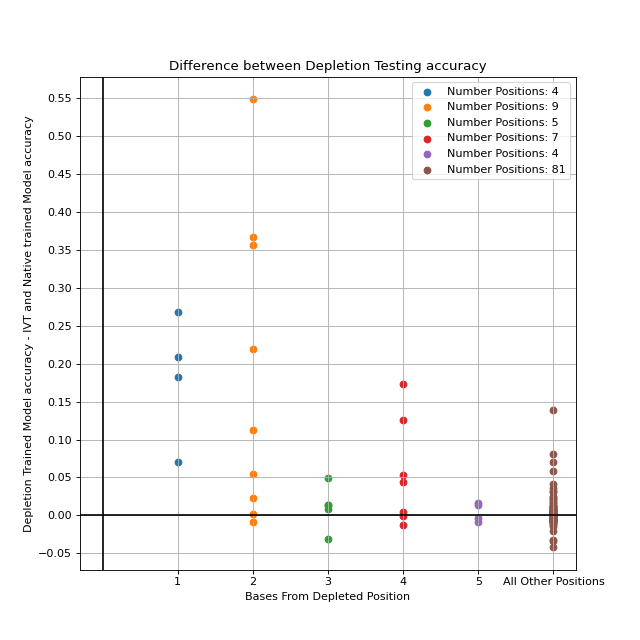

gap 1: {104, 85, 86, 103}
gap 2: {102, 70, 71, 105, 106, 75, 76, 82, 83}
gap 3: {32, 77, 80, 81, 31}
gap 4: {37, 38, 72, 107, 84, 23, 24}
gap 5: {99, 100, 87, 39}


In [20]:
%matplotlib notebook
# matplotlib.use('SVG')
# plt.rcParams['svg.fonttype'] = 'none'
figure_path = figure_path

f, panel1 = plt.subplots(figsize=(8, 8))
panel1.set_title(f'Difference between Depletion Testing {key}')
panel1.set_ylabel(f"Depletion Trained Model {key} - IVT and Native trained Model {key}")
panel1.set_xlabel(f"Bases From Depleted Position")
panel1.set_xticks([x for x in range(1, 7)])
panel1.set_yticks([x for x in np.arange(-1, 1, 0.05)])

panel1.set_xticklabels([str(x) for x in range(1, 6)] + ["All Other Positions"])
panel1.grid()
data = []
seen = set()

for delta in range(1, 6):
    hits1 = get_selector(kpm, delta)
    hits = set(hits1[hits1].index.values) - seen
    print(f"gap {delta}: {hits}")
    tmp_data = (depletions.iloc[list(hits)][key] - ivt_and_native.iloc[list(hits)][key])
    seen |= hits
    data.append(tmp_data)
    panel1.scatter([delta] * len(tmp_data), tmp_data, label=f"Number Positions: {len(tmp_data)}")

tmp_data = (depletions.loc[~depletions.index.isin(list(seen))][key] - 
            ivt_and_native.loc[~ivt_and_native.index.isin(list(seen))][key])

panel1.scatter([delta+1] * len(tmp_data), tmp_data, label=f"Number Positions: {len(tmp_data)}")

panel1.axhline(y=0, color='k')
panel1.axvline(x=0, color='k')

# panel1.boxplot(data)
panel1.legend(loc="upper right")
if figure_path is not None:
#         assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
    plt.savefig(figure_path)
else:
    plt.show()


In [76]:
contig = "RDN25-1"
position = 2255


'Aa'

{'A'}

In [98]:
n = 2255
def get_n_unknown_kmers(contig, pos):
    variant = kpm.mod_handler[(kpm.mod_handler["position"] == pos) & (kpm.mod_handler["contig"] == contig)]["change_to"].iloc[0]
    is_methyl = False
    is_pseudoU = False
    canonical = set("ATGC")
    methyl = set("abcd")
    pseudoU = set("l")
    this_mod = list(set(variant) - canonical)

    if len(set(variant) & methyl) == 1:
        this_mod = list(set(variant) & methyl)[0]
        is_methyl = True
    elif len(set(variant) & pseudoU) == 1:
        is_pseudoU = True

    unknown_kmers = 0
    for x in range(pos-4, pos+1):
        kmers = kpm.get_reference_position_kmers(contig, "+", x)
        n_allowed = np.log2(len(kmers))
        for kmer in kmers:
            mods = [x for x in list(kmer) if x not in canonical]
            n_mods = len(mods)
            if not (n_mods == 0 or n_mods == n_allowed):
                print(this_mod, kmer, mods)
                if is_methyl and (len(set(mods) - pseudoU) == 0):
                    unknown_kmers += 1 
                if is_pseudoU and (len(set(mods) - methyl) == 0):
                    unknown_kmers += 1 
                if not is_pseudoU and not is_methyl and (len(set(mods) - methyl - pseudoU) == 0):
                    unknown_kmers += 1 

    return unknown_kmers
print("unknown_kmers", get_n_unknown_kmers("RDN18-1", 1268))
print("unknown_kmers", get_n_unknown_kmers("RDN18-1", 1186))
print("unknown_kmers", get_n_unknown_kmers("RDN18-1", 1190))

d GGdGG ['d']
d cGTGG ['c']
d TGGdG ['d']
d TcGTG ['c']
d GTGGd ['d']
d GTcGT ['c']
unknown_kmers 0
['l'] gCAGT ['g']
['l'] TCAGl ['l']
unknown_kmers 0
['g'] gCAGT ['g']
['g'] TCAGl ['l']
unknown_kmers 1


<IPython.core.display.Javascript object>


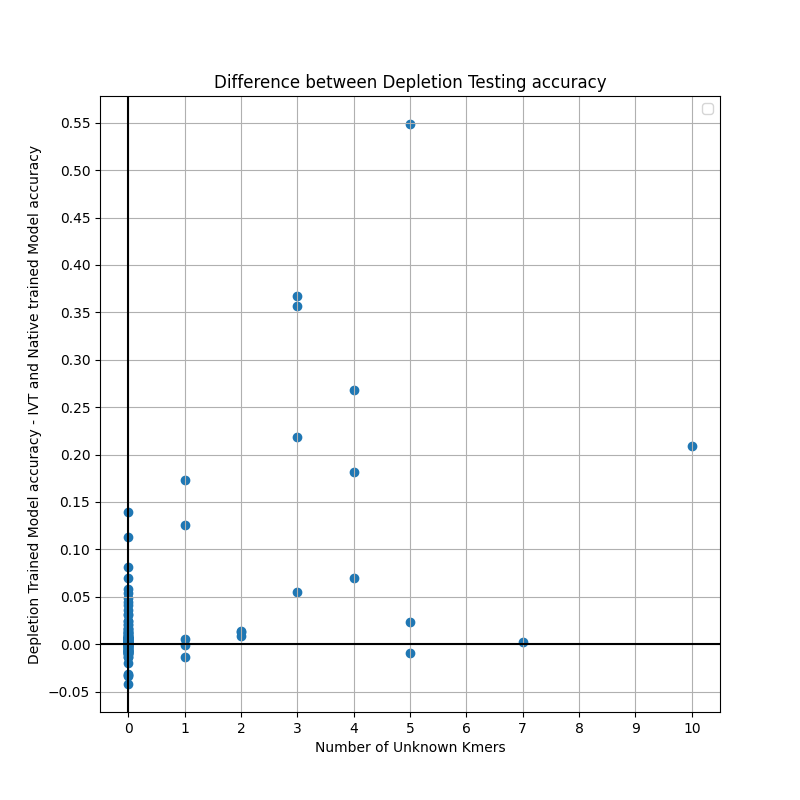

['l'] gCAGT ['g']
['l'] TCAGl ['l']
['g'] gCAGT ['g']
['g'] TCAGl ['l']
d GGdGG ['d']
d cGTGG ['c']
d TGGdG ['d']
d TcGTG ['c']
d GTGGd ['d']
d GTcGT ['c']
c GGdGG ['d']
c cGTGG ['c']
c TGGdG ['d']
c TcGTG ['c']
c GTGGd ['d']
c GTcGT ['c']
c GGAcC ['c']
c kGAGC ['k']
c AkGAG ['k']
c AGGAc ['c']
['k'] GGAcC ['c']
['k'] kGAGC ['k']
['k'] AkGAG ['k']
['k'] AGGAc ['c']
['j'] jAGTG ['j']
['j'] AjGTG ['j']
['j'] CjAGT ['j']
['j'] CAjGT ['j']
['j'] CCjAG ['j']
['j'] CCAjG ['j']
['j'] TCCjA ['j']
['j'] TCCAj ['j']
['j'] jAGTG ['j']
['j'] AjGTG ['j']
['j'] CjAGT ['j']
['j'] CAjGT ['j']
['j'] CCjAG ['j']
['j'] CCAjG ['j']
['j'] TCCjA ['j']
['j'] TCCAj ['j']
['f'] ACAAf ['f']
['f'] aCAAA ['a']
a ACAAf ['f']
a aCAAA ['a']
a bACAA ['b']
a CaCAA ['a']
a GCaCA ['a']
a GbACA ['b']
a GGCaC ['a']
a GGbAC ['b']
a AGGCa ['a']
a AGGbA ['b']
b bACAA ['b']
b CaCAA ['a']
b GCaCA ['a']
b GbACA ['b']
b GGCaC ['a']
b GGbAC ['b']
b AGGCa ['a']
b AGGbA ['b']
c aAGCC ['a']
c AAcCC ['c']
c AAAcC ['c']
c AaAGC ['a']


No handles with labels found to put in legend.


 bGAGT ['b']
b CGaGl ['a', 'l']
b bGAGl ['b', 'l']
b bGaGT ['b', 'a']
b CGaGT ['a']
b CGAGl ['l']
b TbGAG ['b']
b TCGaG ['a']
b GTCGa ['a']
b GTbGA ['b']


In [99]:
%matplotlib notebook
# matplotlib.use('SVG')
# plt.rcParams['svg.fonttype'] = 'none'
figure_path = None

f, panel1 = plt.subplots(figsize=(8, 8))
panel1.set_title(f'Difference between Depletion Testing {key}')
panel1.set_ylabel(f"Depletion Trained Model {key} - IVT and Native trained Model {key}")
panel1.set_xlabel(f"Number of Unknown Kmers")
panel1.set_xticks([x for x in range(0, 26)])
panel1.set_yticks([x for x in np.arange(-1, 1, 0.05)])

# panel1.set_xticklabels([str(x) for x in range(1, 6)] + ["All Other Positions"])
panel1.grid()
data = []
ivt_and_native["acc_diff"] = depletions[key] - ivt_and_native[key]
ivt_and_native["n_missing"] = ivt_and_native.apply(lambda x: get_n_unknown_kmers(x.contig, x.reference_index), axis=1)



panel1.scatter(ivt_and_native["n_missing"], ivt_and_native["acc_diff"])

panel1.axhline(y=0, color='k')
panel1.axvline(x=0, color='k')

# panel1.boxplot(data)
panel1.legend(loc="upper right")
if figure_path is not None:
#         assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
    plt.savefig(figure_path)
else:
    plt.show()


## Kmer distributions Plot
Show difference between trained kmers and prior expectations of kmer distributions

In [24]:
ivt_and_native["acc_diff"] = depletions[key] - ivt_and_native[key]


In [25]:
%matplotlib notebook
ivt_and_native.loc[ivt_and_native.index.isin(list(seen))][["contig", "reference_index", "acc_diff"]]

,contig,reference_index,acc_diff
23,RDN18-1,1186,0.0440
24,RDN18-1,1190,0.0050
31,RDN18-1,1571,0.0490
32,RDN18-1,1574,0.0130
37,RDN25-1,644,-0.0010
38,RDN25-1,648,0.0537
39,RDN25-1,649,-0.0030
70,RDN25-1,2255,0.5487
71,RDN25-1,2257,0.3570
72,RDN25-1,2259,0.1730


In [27]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [24]:
from signalalign.hiddenMarkovModel import HmmModel
model_og_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/small_5mer/test_with_depletions/train_500_test_500_prob_0.7_em_iterations_30_gaussian_true_FREQ_THRESHOLD_0_USE_IVT_TRAINING_true_unsupervised_false_all_kmers_false_small_model_5mer_use_median_true_min_sd_0/training_models/template_hmm30.model"
model_updated_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/small_5mer/depletion/train_500_test_500_prob_0.7_em_iterations_30_gaussian_true_FREQ_THRESHOLD_0_USE_IVT_TRAINING_true_unsupervised_false_all_kmers_false_small_model_5mer_use_median_true_min_sd_0/training_models/template_hmm30.model"

In [25]:
model_og = HmmModel(model_og_path, rna=True)
model_updated = HmmModel(model_updated_path, rna=True)

In [114]:
kmers = ["aCCaT", "aCCbT", "bCCbT", "bCCaT"]
kmers = ["AaCCa", "AaCCb", "AbCCb", "AbCCa"]
# kmers = ["AaCCb", "AbCCa"]
kmers = ["aCCbT", "bCCaT"]

<IPython.core.display.Javascript object>


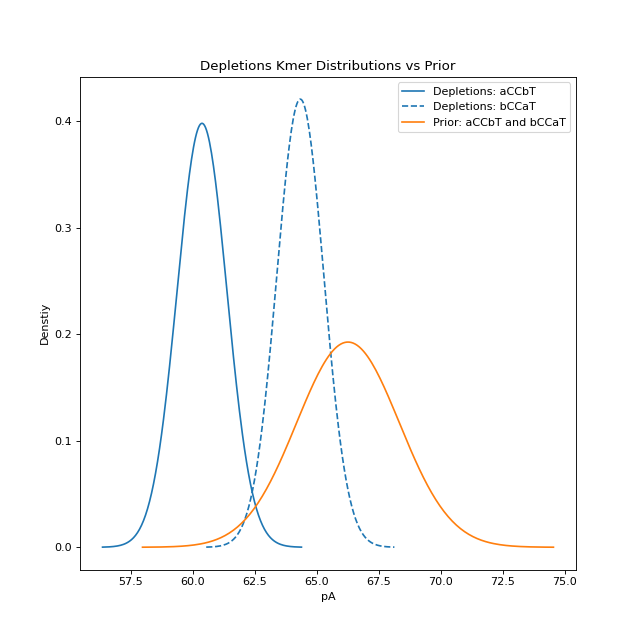

In [115]:
%matplotlib notebook
# matplotlib.use('SVG')
# plt.rcParams['svg.fonttype'] = 'none'
figure_path = os.path.join(output_path, f"{'_'.join(kmers)}.svg")
figure_path = None

f, panel1 = plt.subplots(figsize=(8, 8))
panel1.set_title(f'Depletions Kmer Distributions vs Prior')
panel1.set_ylabel(f"Denstiy")
panel1.set_xlabel(f"pA")
colors = list(mcolors.TABLEAU_COLORS.values())
linestyles = ["-", "--", "-.", ":"]
def plot_label_model(panel1, model, kmer, label, color, linestyle):
    normal_mean, normal_sd = model.get_event_mean_gaussian_parameters(kmer)
    # plot ont normal distribution
    model_x = np.linspace(normal_mean - 4 * normal_sd, normal_mean + 4 * normal_sd, 200)
    model_y = norm.pdf(model_x, normal_mean, normal_sd)
    panel1.plot(model_x, model_y, label=label, 
                color=color, linestyle=linestyle)

for j, kmer in enumerate(kmers):
    plot_label_model(panel1, model_updated, kmer, f"Depletions: {kmer}", colors[0], linestyles[j])

plot_label_model(panel1, model_og, kmer, f"Prior: {' and '.join(kmers)}", colors[1], linestyles[0])

    # panel1.boxplot(data)
panel1.legend(loc="upper right")
if figure_path is not None:
#         assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
    plt.savefig(figure_path)
else:
    plt.show()

In [116]:
depleted_kmers = ["aCCbT", "bCCaT"]
can_kmers = ["aCCaT"]
native_kmers = ["bCCbT"]
kmers = ["aCCaT", "aCCbT", "bCCbT", "bCCaT"]


In [124]:
%matplotlib notebook
matplotlib.use('SVG')
plt.rcParams['svg.fonttype'] = 'none'
kmers = ["aCCaT", "aCCbT", "bCCbT", "bCCaT"]
figure_path = os.path.join(output_path, f"{'_'.join(kmers)}.svg")
# figure_path = None

f, panel1 = plt.subplots(figsize=(8, 8))
panel1.set_title(f'Comparison of Multiple Path Kmers')
panel1.set_ylabel(f"Denstiy")
panel1.set_xlabel(f"pA")
colors = list(mcolors.TABLEAU_COLORS.values())
linestyles = ["-", "--", "-.", ":"]
def plot_label_model(panel1, model, kmer, label, color, linestyle):
    normal_mean, normal_sd = model.get_event_mean_gaussian_parameters(kmer)
    # plot ont normal distribution
    model_x = np.linspace(normal_mean - 4 * normal_sd, normal_mean + 4 * normal_sd, 200)
    model_y = norm.pdf(model_x, normal_mean, normal_sd)
    panel1.plot(model_x, model_y, label=label, 
                color=color, linestyle=linestyle)

plot_label_model(panel1, model_updated, "aCCaT", f"IVT: aCCaT", colors[0], linestyles[0])
plot_label_model(panel1, model_updated, "aCCbT", f"CBF5 GLU: aCCbT", colors[1], linestyles[0])
plot_label_model(panel1, model_updated, "bCCaT", f"Nop58 GLU: bCCaT", colors[2], linestyles[0])
plot_label_model(panel1, model_updated, "bCCbT", f"Native: bCCbT", colors[3], linestyles[0])

plot_label_model(panel1, model_og, kmer, f"Prior: bCCaT and aCCbT", colors[4], linestyles[0])

    # panel1.boxplot(data)
panel1.legend(loc="upper left")
if figure_path is not None:
#         assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
    plt.savefig(figure_path)
else:
    plt.show()